In [20]:
# imports
import sys
sys.path.append( '..' )

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from helpers.normalization import *
from FIA import *
from ML.ML4com import *
sns.set_theme(rc={"figure.figsize":(12, 6)})

In [2]:
# Load matrices
strains = pd.read_csv("/mnt/d/data/Com8_grown_together/strains.tsv", sep="\t")
comm8 = pd.read_csv("/mnt/d/data/Com8_grown_together/comm8.tsv", sep="\t")
metData = pd.read_csv("/mnt/d/data/Com8_grown_together/metData.tsv", sep="\t")
metData.index = pd.read_csv("/mnt/d/data/Com8_grown_together/metName.tsv", sep="\t")

met_raw_pos = pd.read_excel("/mnt/d/data/Com8_grown_together/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="pos")
met_raw_neg = pd.read_excel("/mnt/d/data/Com8_grown_together/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="neg")
met_raw_comb = pd.concat( [total_ion_count_normalization( join_df_metNames(met_raw_pos) ),
                           total_ion_count_normalization( join_df_metNames(met_raw_neg) )] )

In [3]:
X = met_raw_comb.transpose()

In [4]:
from scipy.stats import ttest_ind, mannwhitneyu, f_oneway
from statsmodels.sandbox.stats.multicomp import multipletests

In [5]:
def test_metabolites_organism(data, community_composition, organism_idx, alpha, test):
    in_bool = [True if i==1 else False for i in community_composition.iloc[:,organism_idx].values]
    data_in = data[in_bool]
    data_notin = data[np.invert(in_bool)]

    statistic, p_values = test(data_in, data_notin)
    results = multipletests(p_values, alpha=alpha, method="bonferroni")
    
    fc = data_in.mean() / data_notin.mean()

    stats = pd.DataFrame({"sig":results[0], "p":results[1], "fc":fc.values,
                          "-log10p":-np.log10(results[1]), "log2fc":np.log2(fc.values)}).T
    stats.columns = data.columns
    return (pd.concat([data.copy(), stats]), in_bool)

In [6]:
results = test_metabolites_organism(data=X, community_composition=comm8, organism_idx=0, alpha=1e-21, test=f_oneway)

## Plotting

In [7]:
import plotly.express as px

In [8]:
def plot_volcanos(df, color_map:dict, sig_p:float=None, sig_fc_pos:float=None, sig_fc_neg:float=None, show_labels:bool=True, width:int=1600, height:int=900, outfolder:str="."):
    figures = {}
    test_stats = {}
    includes = {}
    for e, org in enumerate(strains["Organism"]):
        test_stat, included = test_metabolites_organism(data=X, community_composition=comm8,
                                                        organism_idx=e, alpha=1e-21, test=f_oneway)

        colors = []
        labels = []
        text = []
        for idx, row in test_stat.T.iterrows():
            labels.append(idx)
            if sig_p and row["p"] <= sig_p:
                if  sig_fc_pos and row["fc"] >= sig_fc_pos:
                    colors.append("significant + high positive fold-change")
                    text.append(idx)

                elif sig_fc_neg and row["fc"] <= sig_fc_neg:
                    colors.append("significant + high negative fold-change")
                    text.append(idx)

                else:
                    colors.append("significant")
                    text.append("")
            
            else:
                if sig_fc_pos and row["fc"] >= sig_fc_pos:
                    colors.append("high positive fold change")
                    text.append("")


                elif sig_fc_neg and row["fc"] <= sig_fc_neg:
                    colors.append("high negative fold change")
                    text.append("")

                else:
                    colors.append("")
                    text.append("")

        df = pd.DataFrame()
        df["log2 fold-change"] = test_stat.loc["log2fc"]
        df["-log10 p-value"] =  test_stat.loc["-log10p"]
        df["fold-change"] =  test_stat.loc["fc"]
        df["p-value"] =  test_stat.loc["p"]
        text = labels if show_labels else [""]*len(test_stat.columns)
        figure = px.scatter(df,
                            x = "log2 fold-change",
                            y = "-log10 p-value",
                            title = org,
                            text= text,
                            hover_name = labels,
                            hover_data=["p-value", "fold-change"],
                            color = colors,
                            color_discrete_map = color_map)
        if sig_fc_pos:
            figure.add_vline(x=np.log2(sig_fc_pos), line_width=1, line_dash="dash", line_color="grey")
        if sig_fc_neg:
            figure.add_vline(x=np.log2(sig_fc_neg), line_width=1, line_dash="dash", line_color="grey")
        if sig_p:
            figure.add_hline(y=-1 * np.log10(sig_p), line_width=1, line_dash="dash", line_color="grey")
        figure.update_traces(textposition='top center')
        figure.add_vline(x=0, line_width=1, line_color='black')
        figure.add_hline(y=0, line_width=1, line_color='black')

        figures[org] = figure
        test_stat.loc["position"] = colors
        test_stats[org] = test_stat
        includes[org] = included

        if not os.path.isdir(outfolder):
            os.mkdir(outfolder)
        figure.write_image(f"{outfolder}/volcano_{org}.png", width=width, height=height)
    return (figures, test_stats, includes)

In [9]:
color_map = {"": "lightgrey",
            "significant + high positive fold-change": "red",
            "significant + high negative fold-change": "orange",
            "significant": "violet",
            "high positive fold change": "blue",
            "high negative fold change": "blue"}

figures, test_stats, includes = plot_volcanos(X, sig_p=0.05, sig_fc_pos=4, sig_fc_neg=0.25, color_map=color_map, show_labels=False, outfolder="../../reports/FIA/metabalysis")

## Inspection

In [10]:
def extract_metabolites_of_interest(test_stats):
    met_of_interest = {}
    p_vals = {}
    for org, ts in test_stats.items():
        query = ts.loc["position"].values == "significant + high positive fold-change"
        query += ts.loc["position"].values == "significant + high negative fold-change"
        include = [idx not in ["sig", "p", "fc", "-log10p", "log2fc", "position"] for idx in ts.index] 
        met_of_interest[org] = ts.loc[include, query]  
        p_vals[org] = ts.loc["p", query]        
    return met_of_interest, p_vals

In [11]:
metabs_of_interest, p_vals = extract_metabolites_of_interest(test_stats)

In [12]:
def p_val_to_star(p:float):
    if p < 1e-4:
        return "****"
    elif p < 1e-3:
        return "***"
    elif p < 1e-2:
        return "**"
    elif p < 5e-2:
        return "*"
    else:
        return "ns"

def significance_plot(df, includes, p_vals, title):
    fig = plt.figure()
    plot_df = df.copy()
    plot_df["included"] = includes
    plot_df = plot_df.melt(id_vars=["included"])
    ax = sns.boxplot(plot_df, x="metNames", y="value", hue="included")
    for i, met in enumerate(plot_df["metNames"].unique()):
        col = df.columns[i]
        h = 0.0005
        y = np.max(plot_df[plot_df["metNames"] == col]["value"]) + h
        x1, x2 = (i -0.2, i+ 0.2)
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.0, c="black")
        ax.text((x1 + x2)*0.5, y+ h, p_val_to_star(p_vals[col]), ha='center', va='bottom', color="black")
    ax.set(title=title)
    ax.tick_params(axis='x', rotation=90)
    return fig

def significance_plot_batch(targets_of_interest, includes, p_vals):
    plots = {}
    for org, target_of_interest in targets_of_interest.items():
        plots[org] = significance_plot(target_of_interest, includes[org], p_vals[org], org)
    return plots

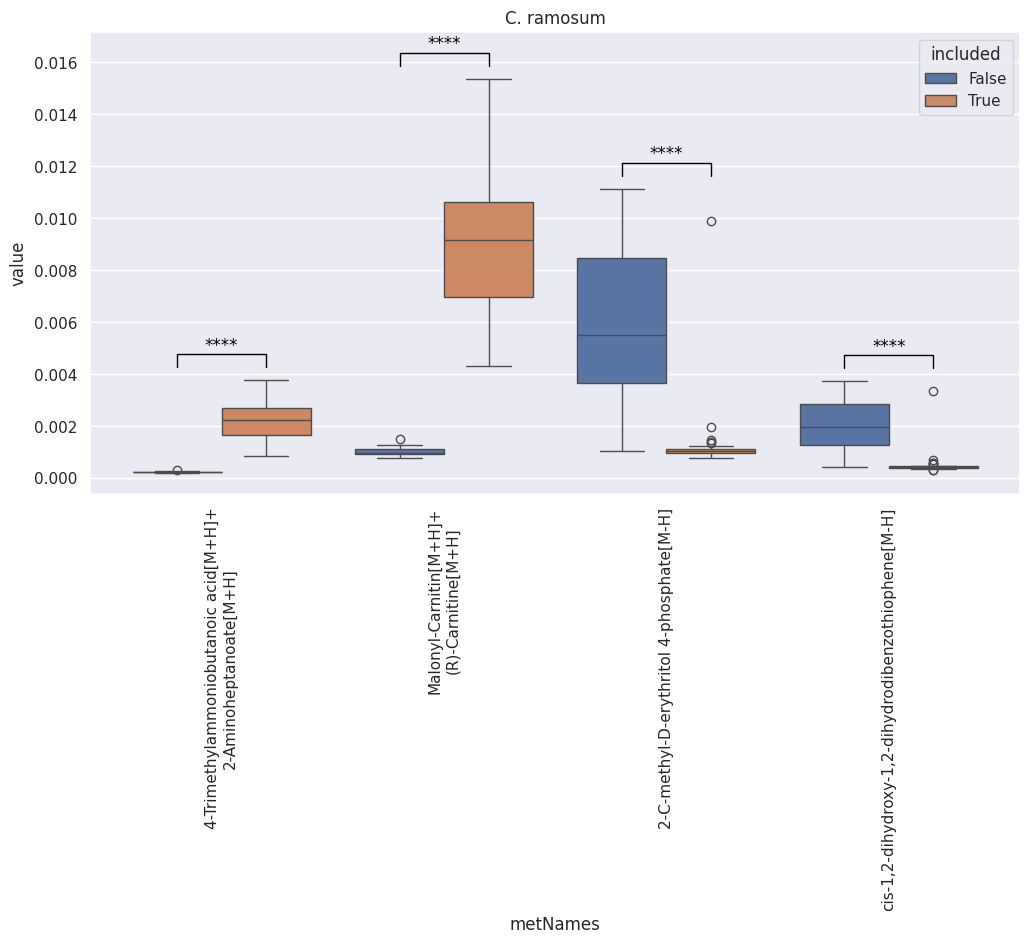

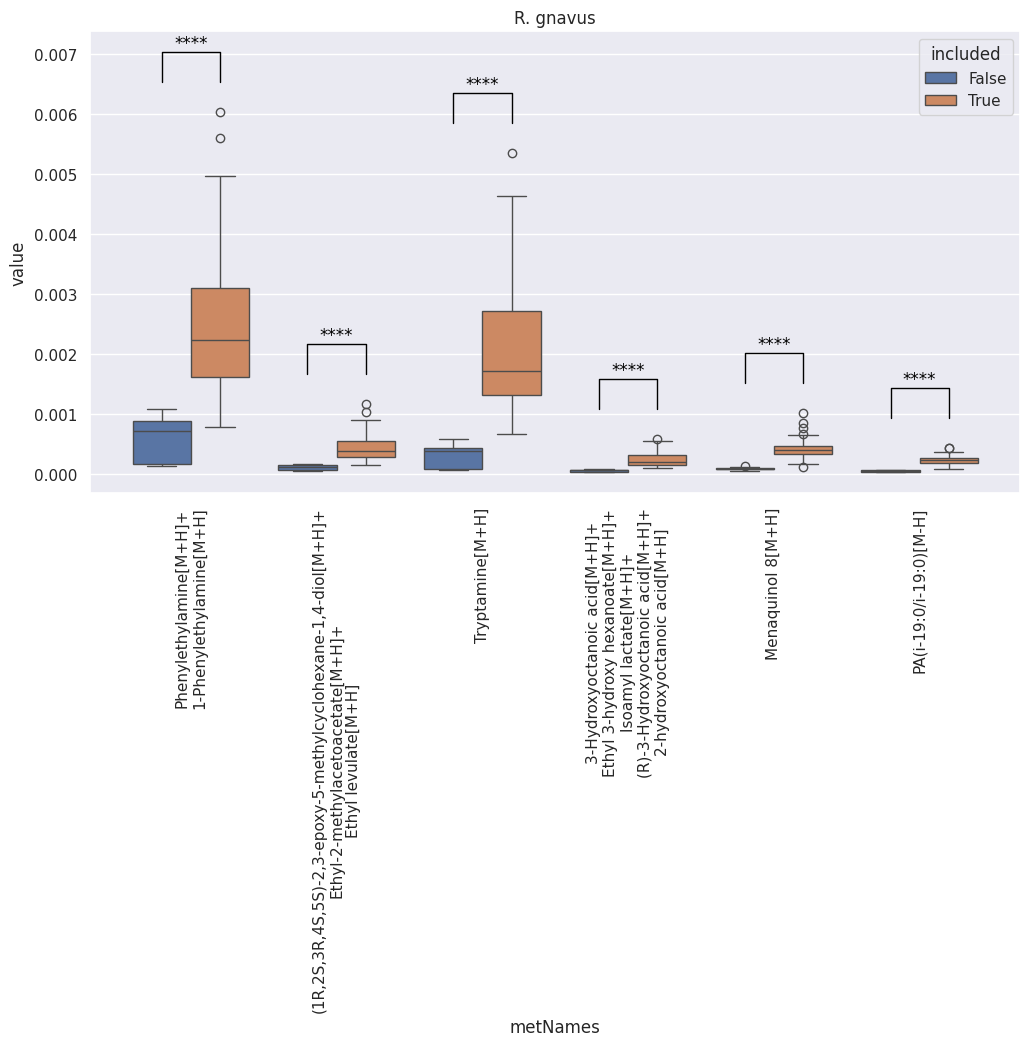

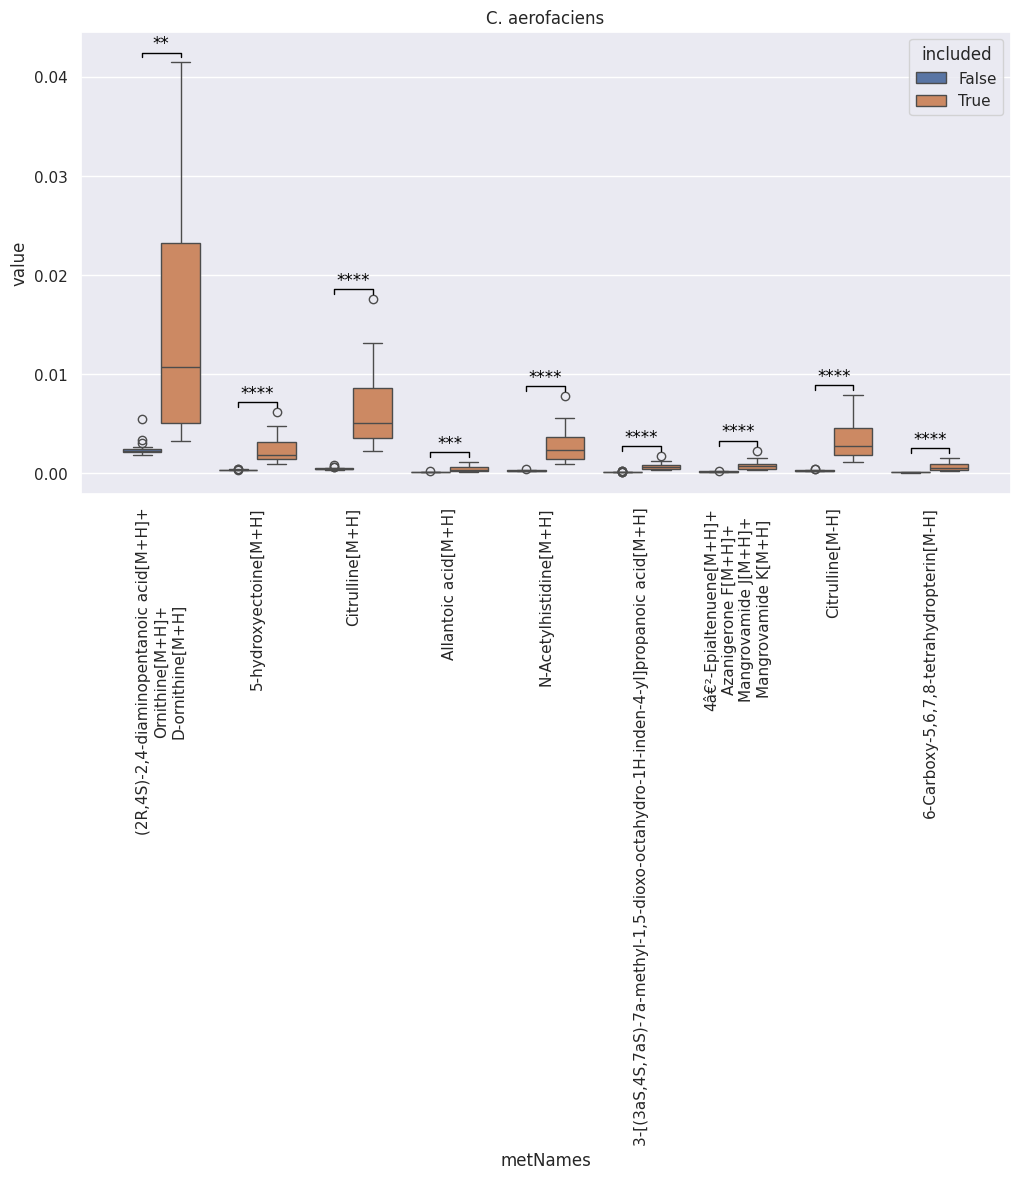

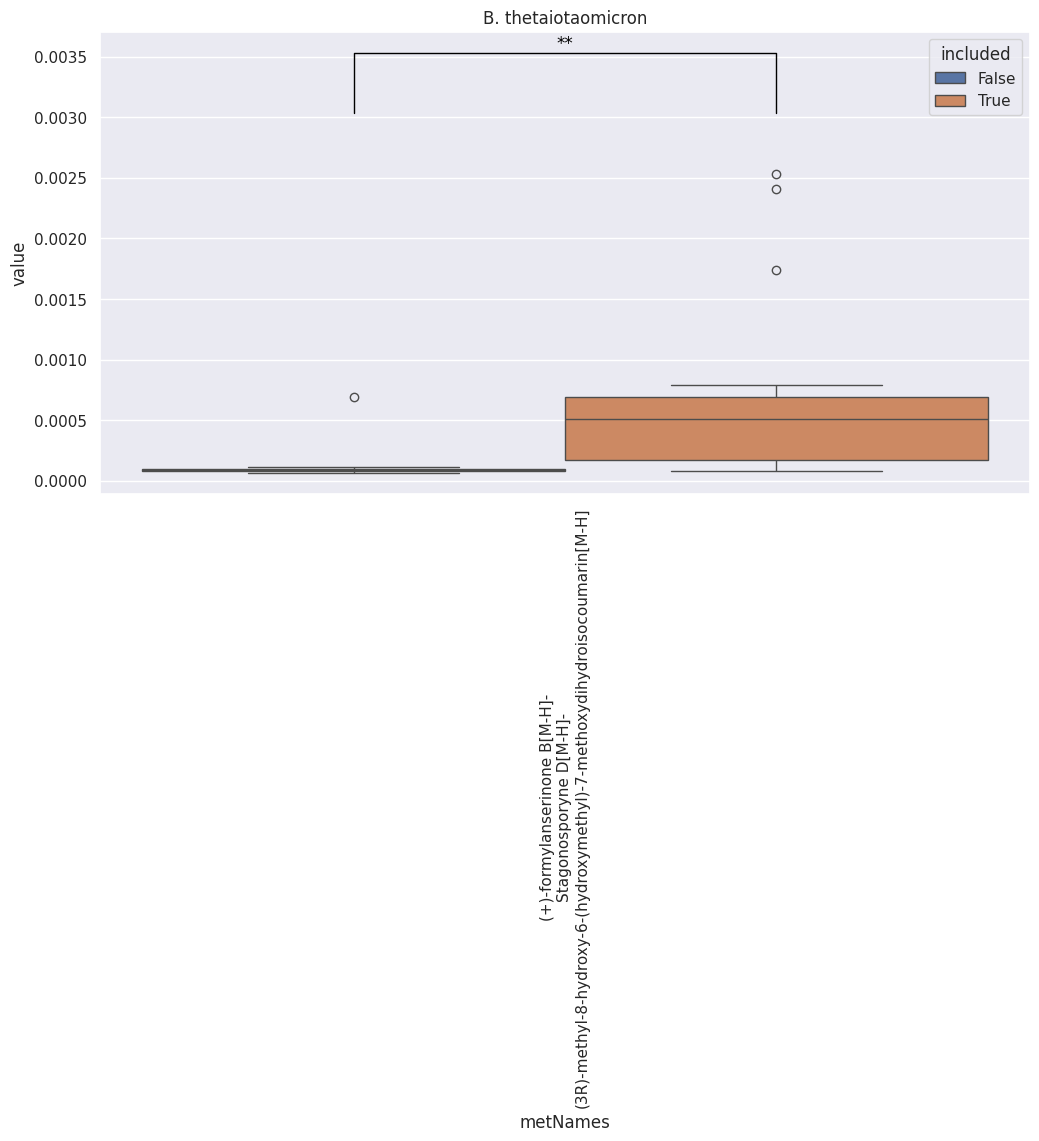

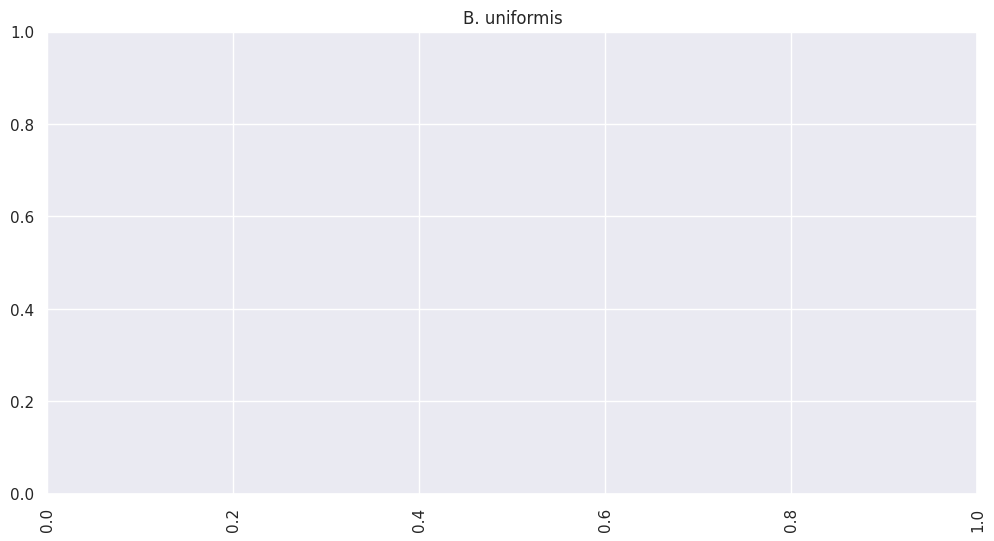

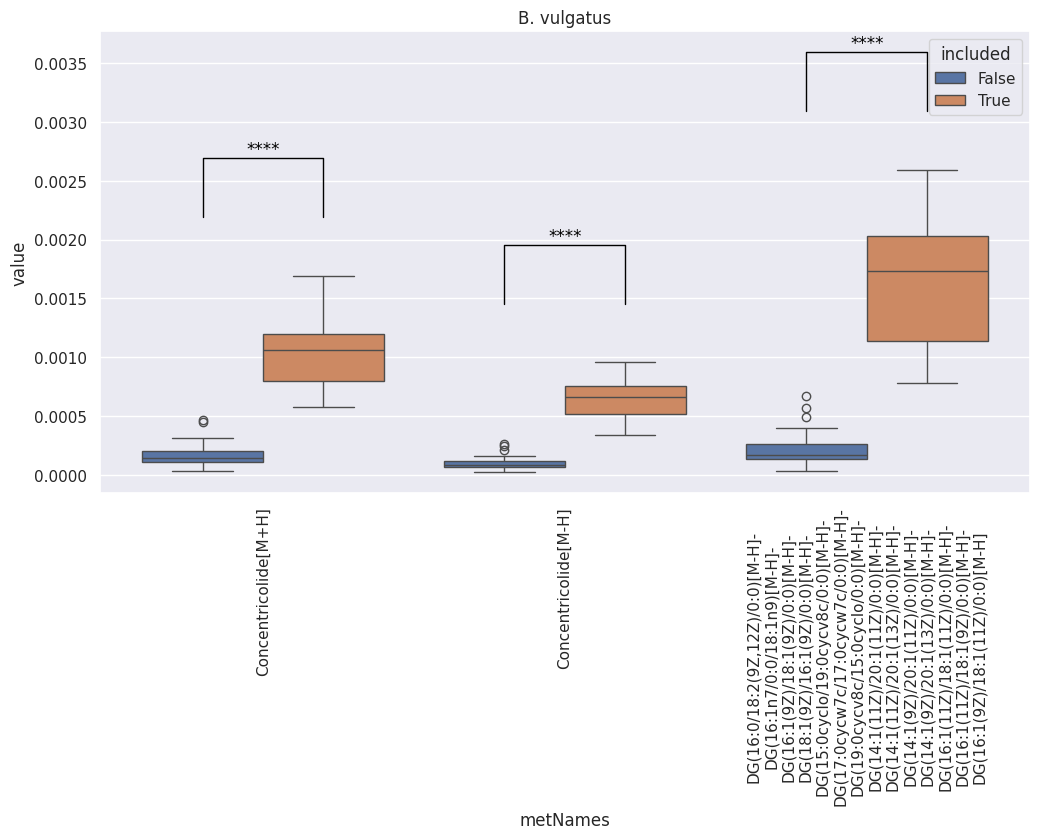

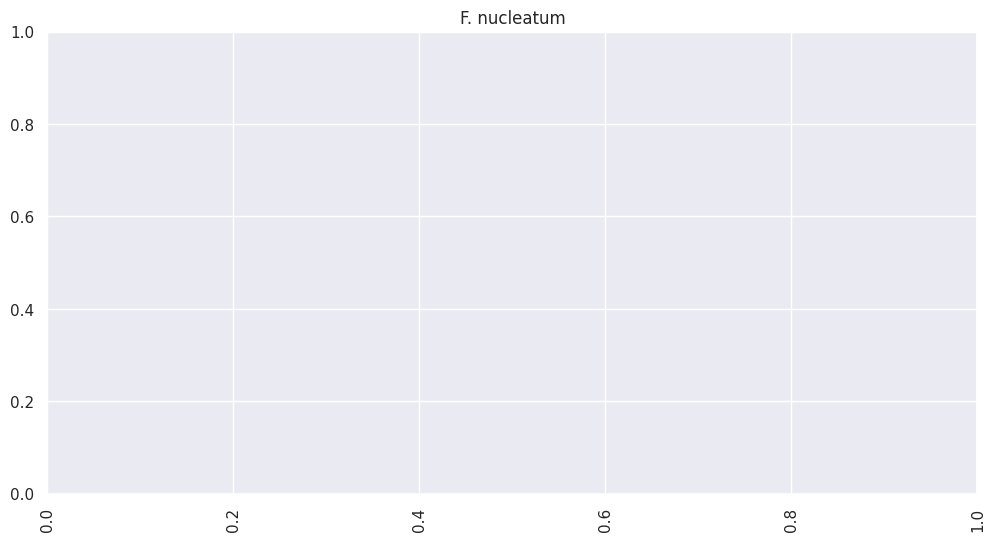

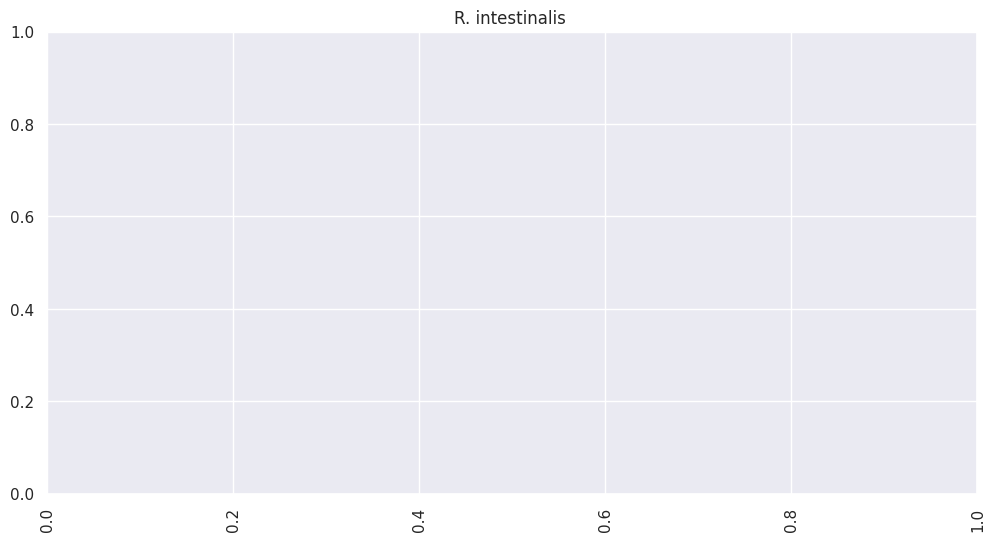

In [13]:
plots = significance_plot_batch(metabs_of_interest, includes, p_vals)

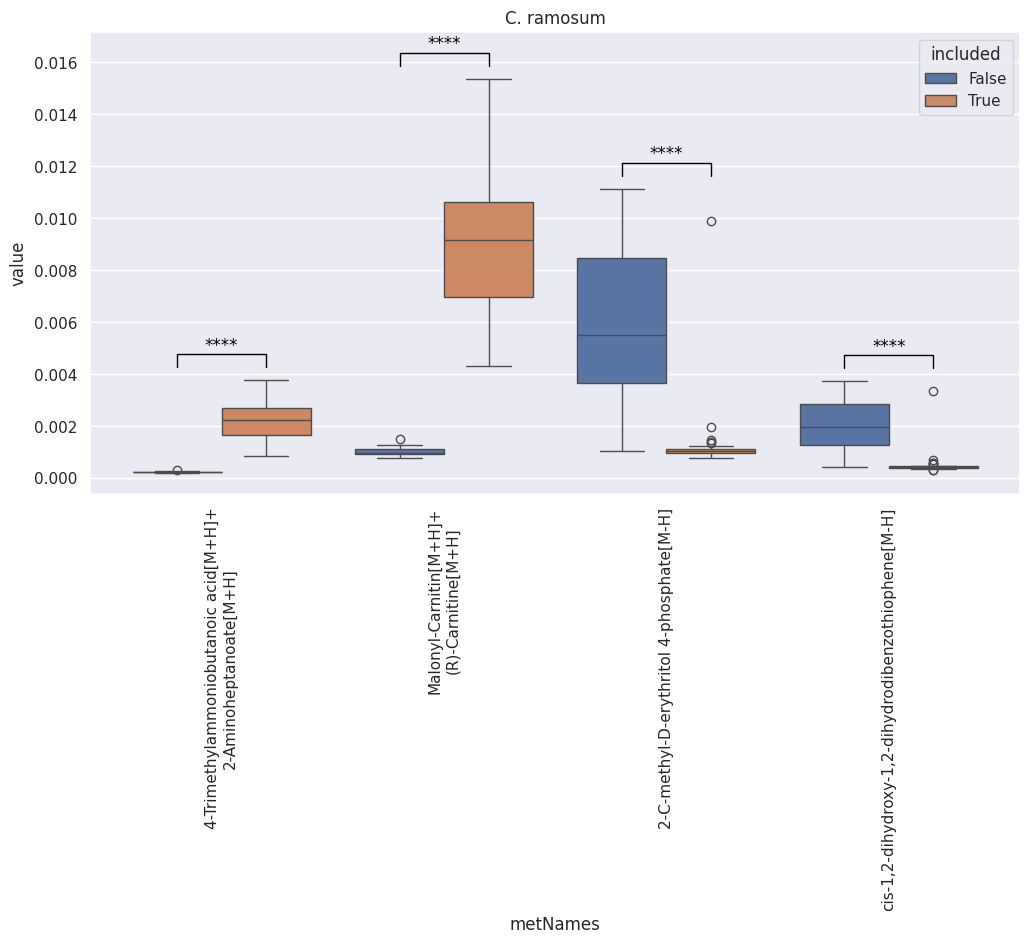

In [14]:
plots.get("C. ramosum")

## Comparison to classification

In [15]:
def significance_importance_plot(sig_df, imp_df, includes, p_vals, title):
    fig = plt.figure()
    plot_df = sig_df.copy()
    plot_df["included"] = includes
    plot_df = plot_df.melt(id_vars=["included"])

    ax = sns.boxplot(plot_df, x="metNames", y="value", hue="included")
    for i, met in enumerate(plot_df["metNames"].unique()):
        col = sig_df.columns[i]
        h = 0.0005
        y = np.max(plot_df[plot_df["metNames"] == col]["value"]) + h
        x1, x2 = (i -0.2, i+ 0.2)
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.0, c="black")
        ax.text((x1 + x2)*0.5, y+ h, p_val_to_star(p_vals[col]), ha='center', va='bottom', color="black")

    imp_df = imp_df.loc[[metName in plot_df["metNames"].unique() for metName in imp_df["metNames"].values], [title, "metNames"]]
    imp_df.rename(columns={title: "feature importance"}, inplace=True)
    ax_twin = ax.twinx()
    ax2 = sns.barplot(imp_df, x="metNames", y="feature importance", ax=ax_twin,  alpha=0.2, width=0.9, palette=["violet"])
    ax2.set_ylim(bottom=0.0, top=1.0)
    ax2.grid(False)

    ax.set(title=title)
    ax.tick_params(axis='x', rotation=90)
    return fig

def significance_importance_plot_batch(targets_of_interest, importances_df, includes, p_vals):
    plots = {}
    for org, target_of_interest in targets_of_interest.items():
        plots[org] = significance_importance_plot(target_of_interest, importances_df, includes[org], p_vals[org], org)
    return plots

In [16]:
importances_df = pd.read_csv("../../reports/ML/XGBoost/feature_importance_2.tsv", sep="\t")

/tmp/ipykernel_159251/3864525823.py:19: UserWarning:


The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.

/tmp/ipykernel_159251/3864525823.py:19: UserWarning:


The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.

/tmp/ipykernel_159251/3864525823.py:19: UserWarning:


The palette list has fewer values (1) than needed (9) and will cycle, which may produce an uninterpretable plot.

/tmp/ipykernel_159251/3864525823.py:19: UserWarning:


The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.



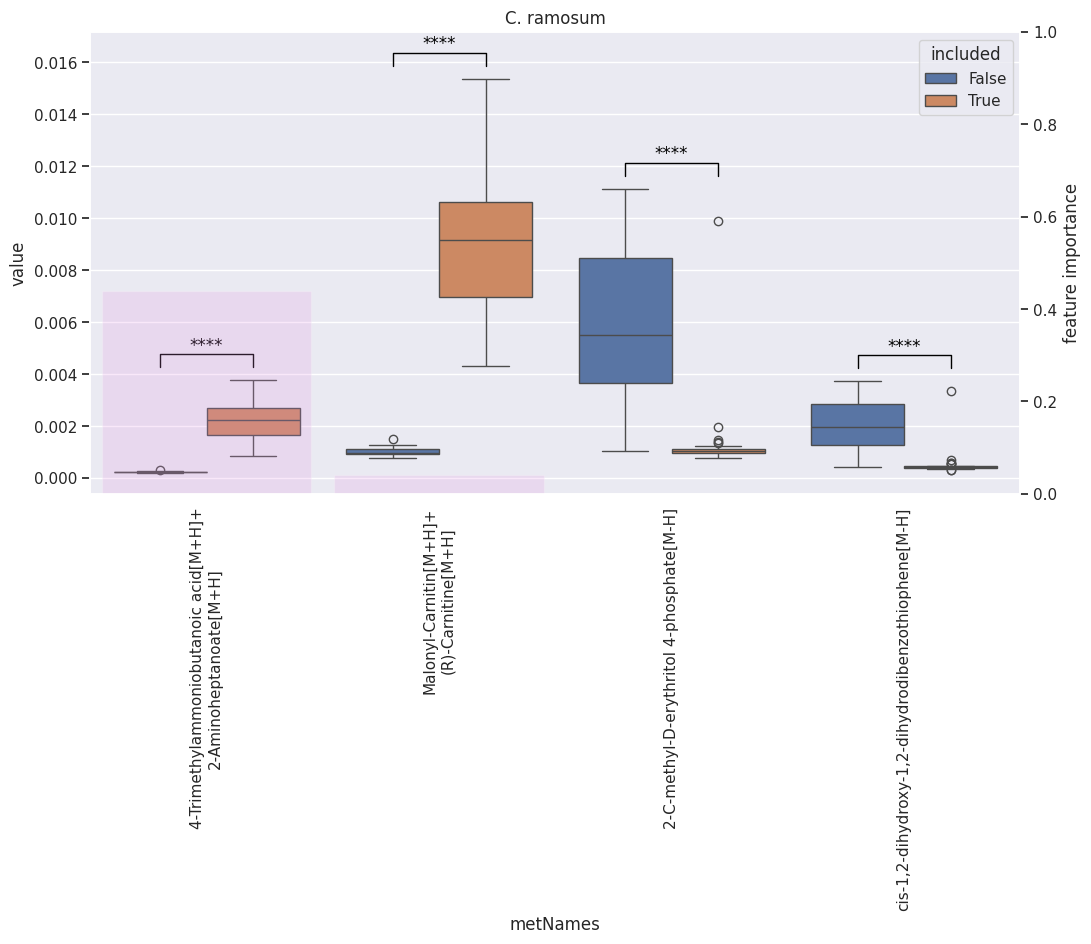

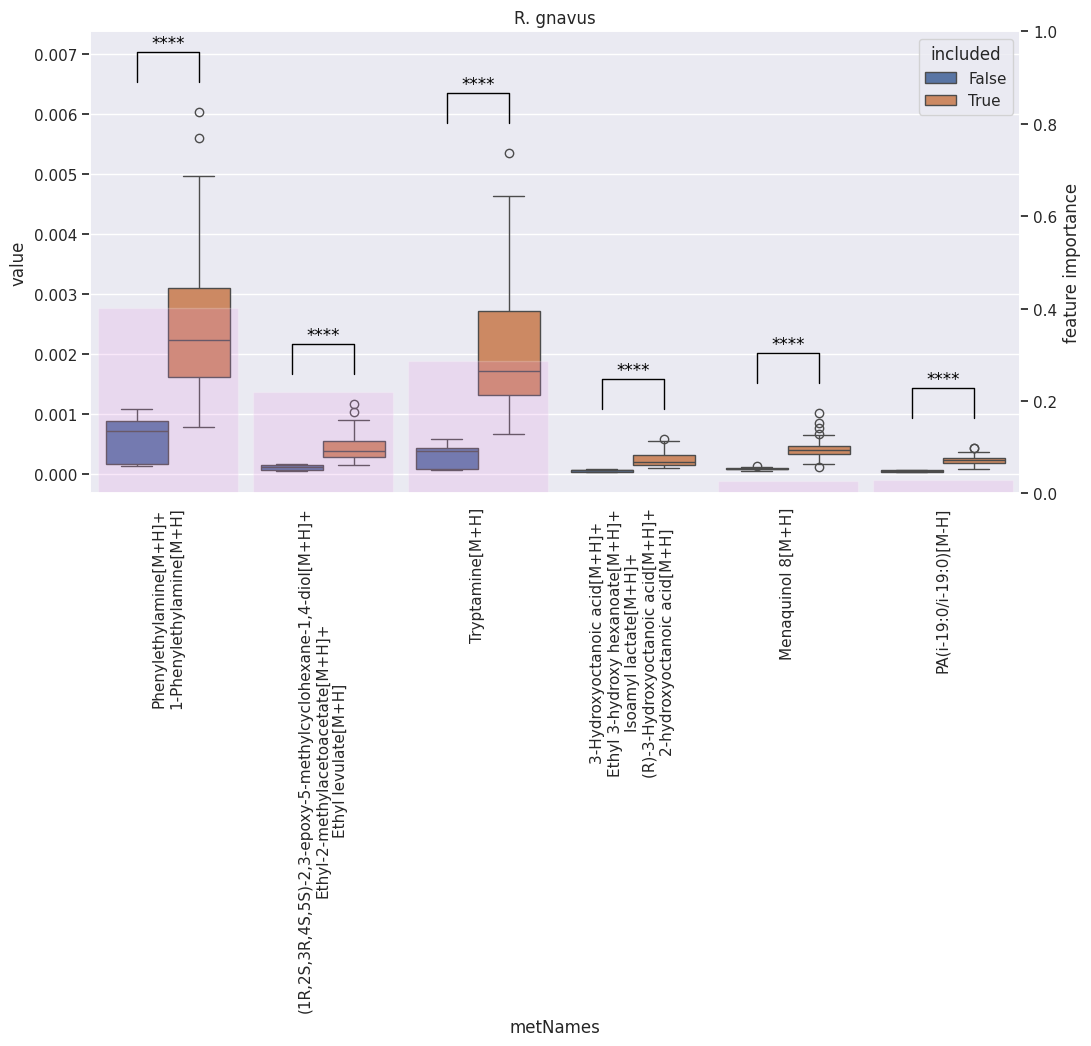

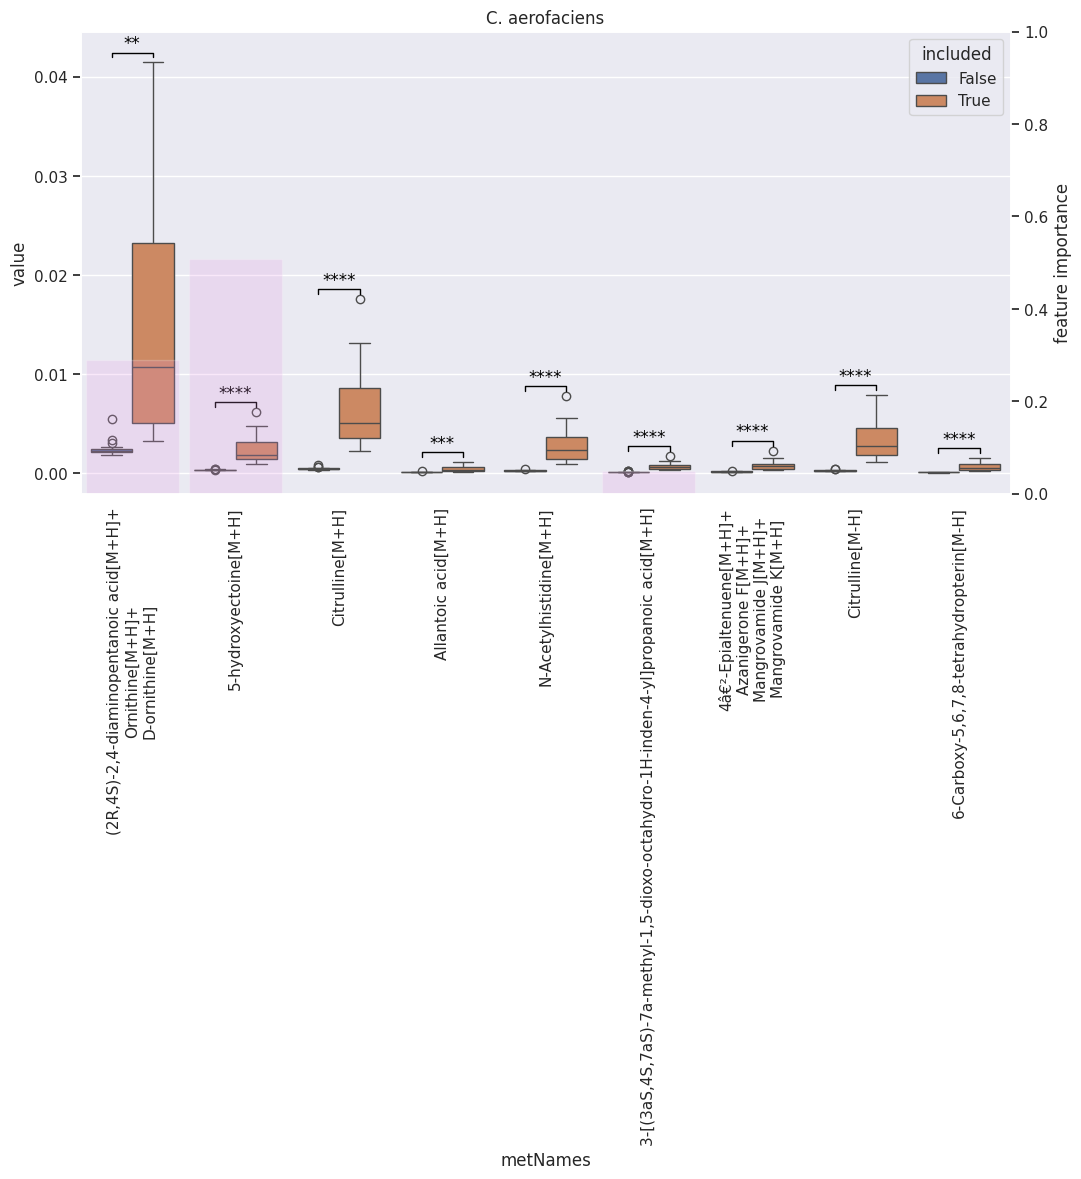

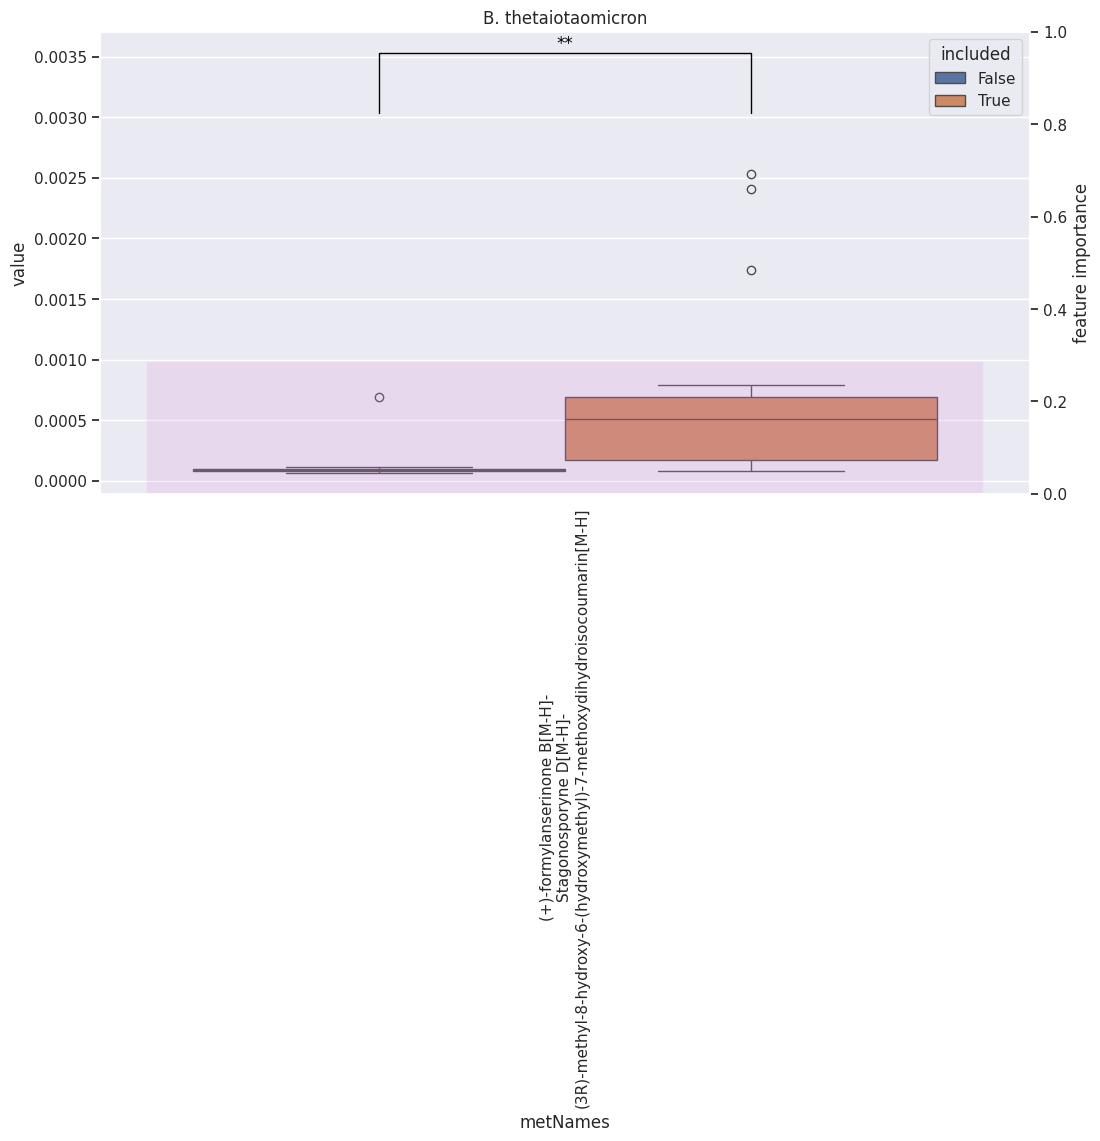

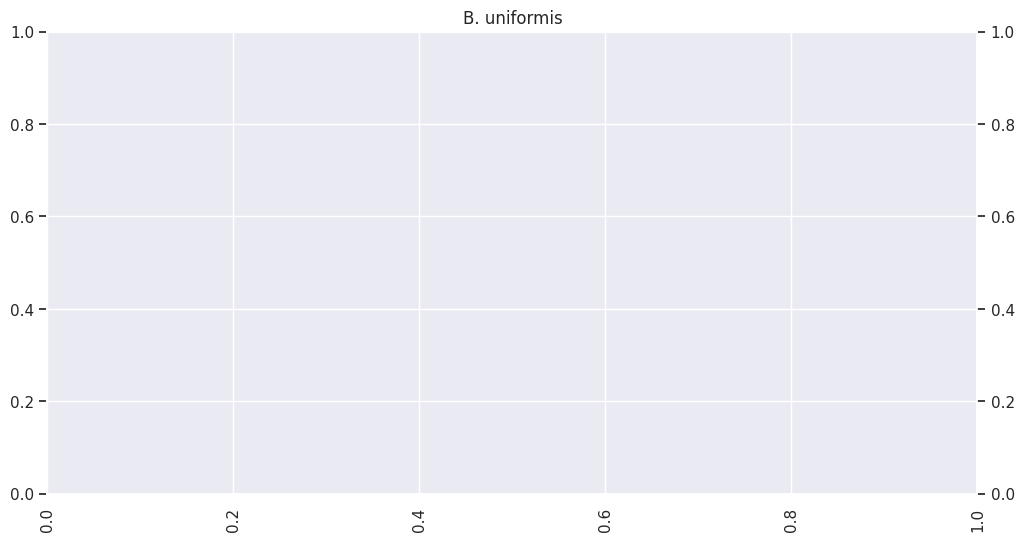

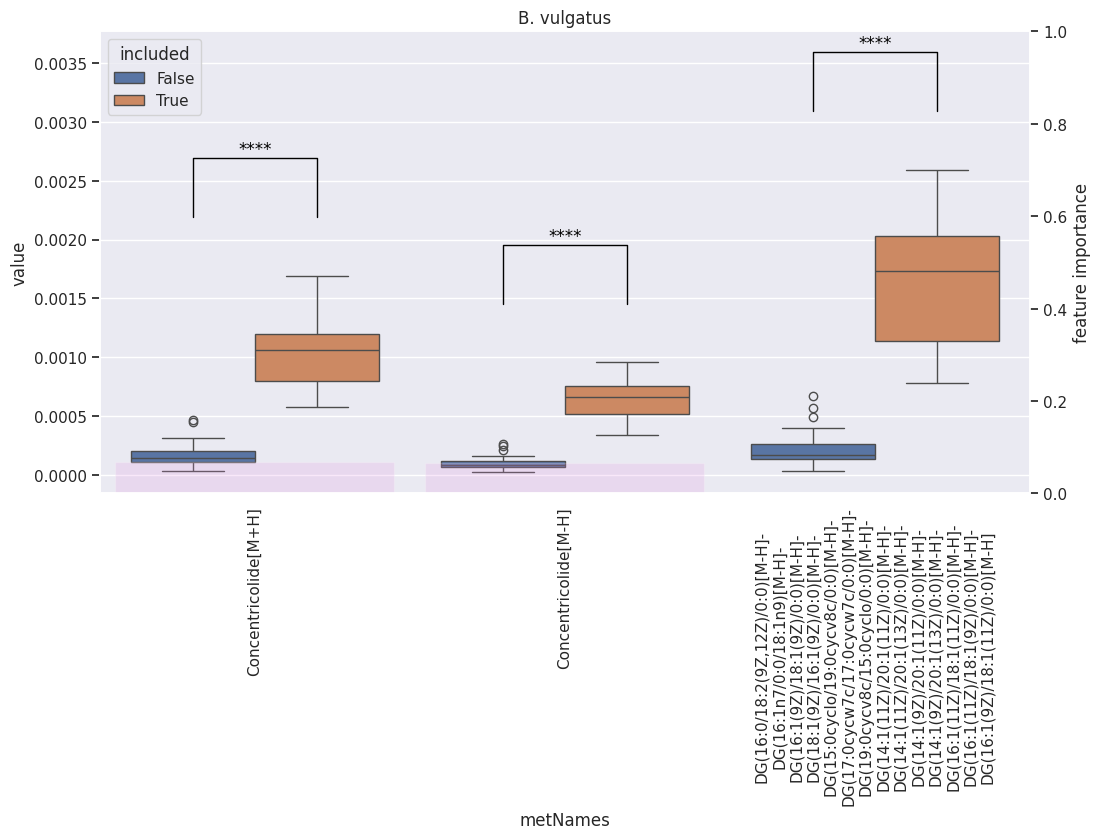

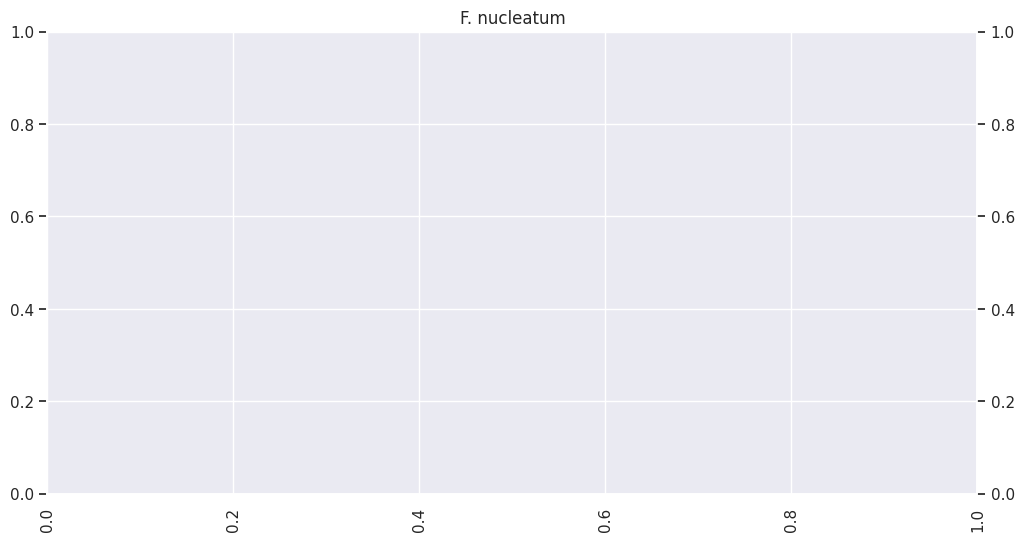

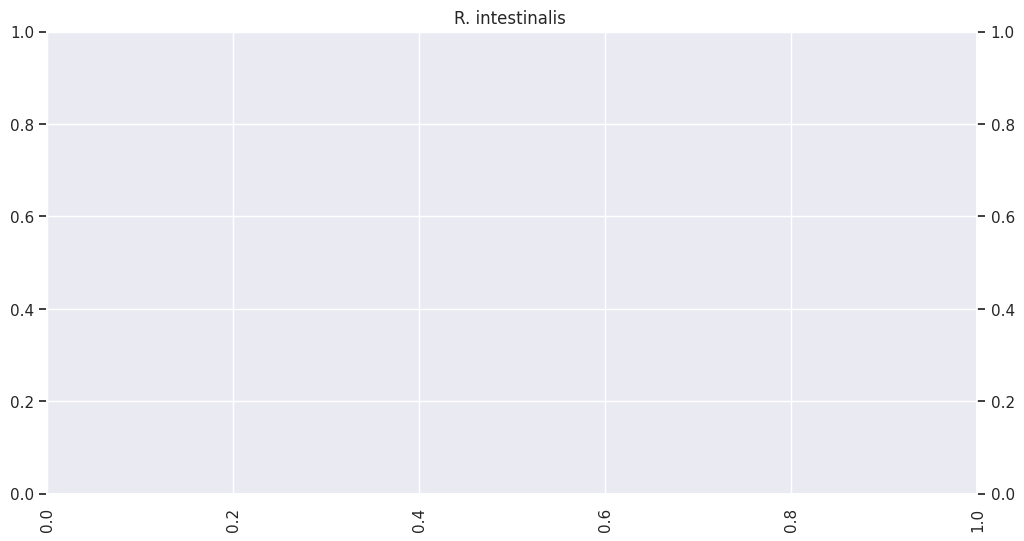

In [17]:
plots = significance_importance_plot_batch(metabs_of_interest, importances_df, includes, p_vals)

### Other way around

In [18]:
def importance_significance_plot(sig_df, imp_df, includes, title):
    fig = plt.figure()
    imp_df = imp_df.loc[imp_df[title] > 0.05 , [title, "metNames"]]
    imp_df.rename(columns={title: "feature importance"}, inplace=True)

    plot_df = sig_df.copy()
    p_vals = plot_df.loc["p"]
    plot_df = plot_df.loc[[idx not in ["sig", "p", "fc", "-log10p", "log2fc", "position"] for idx in plot_df.index]]
    plot_df["included"] = includes
    plot_df = plot_df.melt(id_vars=["included"])
    plot_df = plot_df.loc[[metName in imp_df["metNames"].unique() for metName in plot_df["metNames"].values]]

    ax = sns.boxplot(plot_df, x="metNames", y="value", hue="included")
    for i, met in enumerate(plot_df["metNames"].unique()):
        h = 0.0005
        y = np.max(plot_df[plot_df["metNames"] == met]["value"]) + h
        x1, x2 = (i -0.2, i+ 0.2)
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.0, c="black")
        ax.text((x1 + x2)*0.5, y+ h, p_val_to_star(p_vals[met]), ha='center', va='bottom', color="black")

    ax_twin = ax.twinx()
    ax2 = sns.barplot(imp_df, x="metNames", y="feature importance", ax=ax_twin,  alpha=0.2, width=0.9, palette=["violet"])
    ax2.set_ylim(bottom=0.0, top=1.0)
    ax2.grid(False)

    ax.set(title=title)
    ax.tick_params(axis='x', rotation=90)
    return fig

def importance_significance_plot_batch(targets_of_interest, importances_df, includes):
    plots = {}
    for org, target_of_interest in targets_of_interest.items():
        plots[org] = importance_significance_plot(target_of_interest, importances_df, includes[org], org)
    return plots

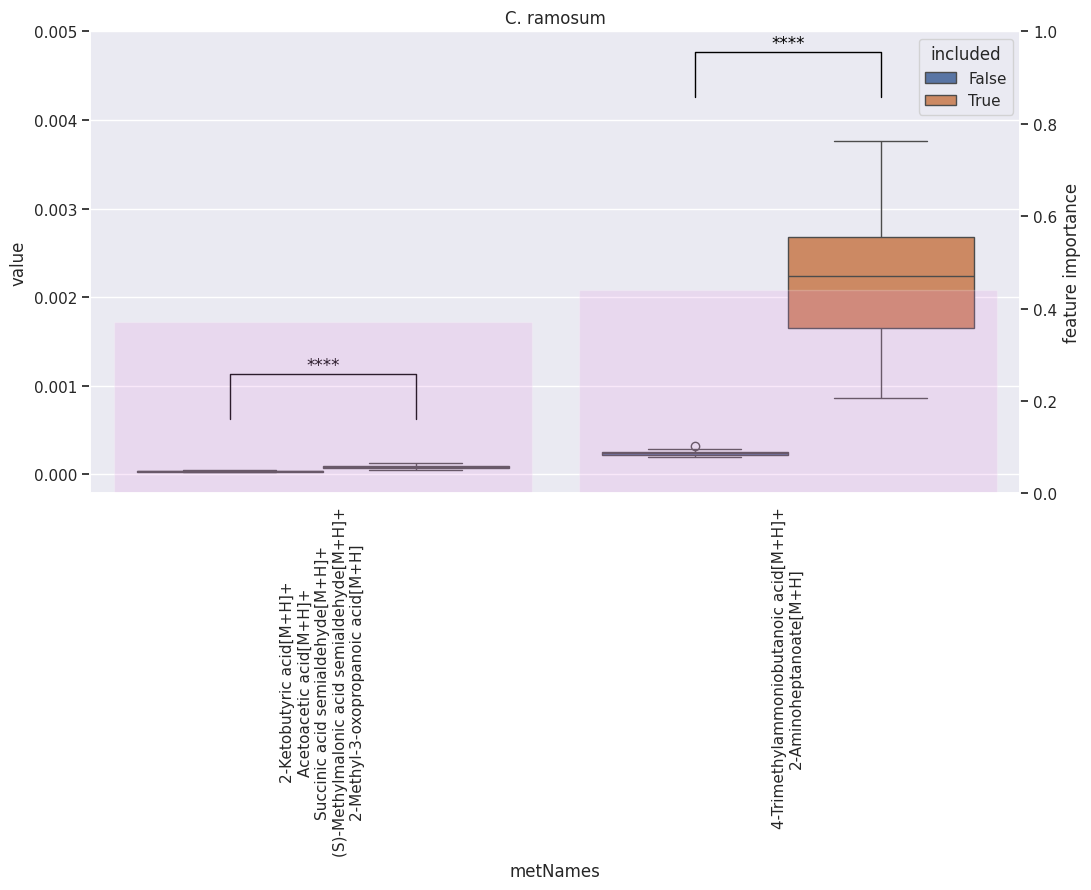

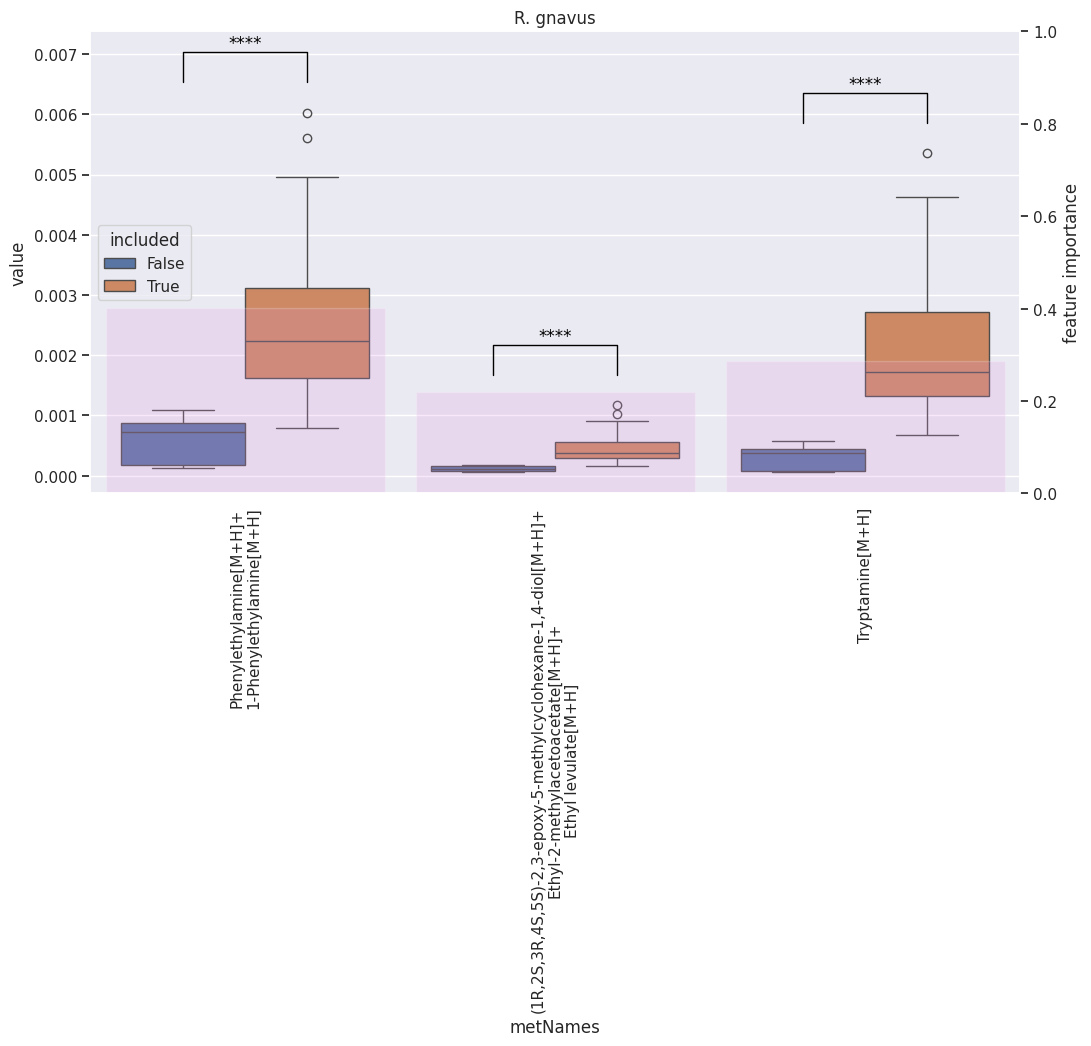

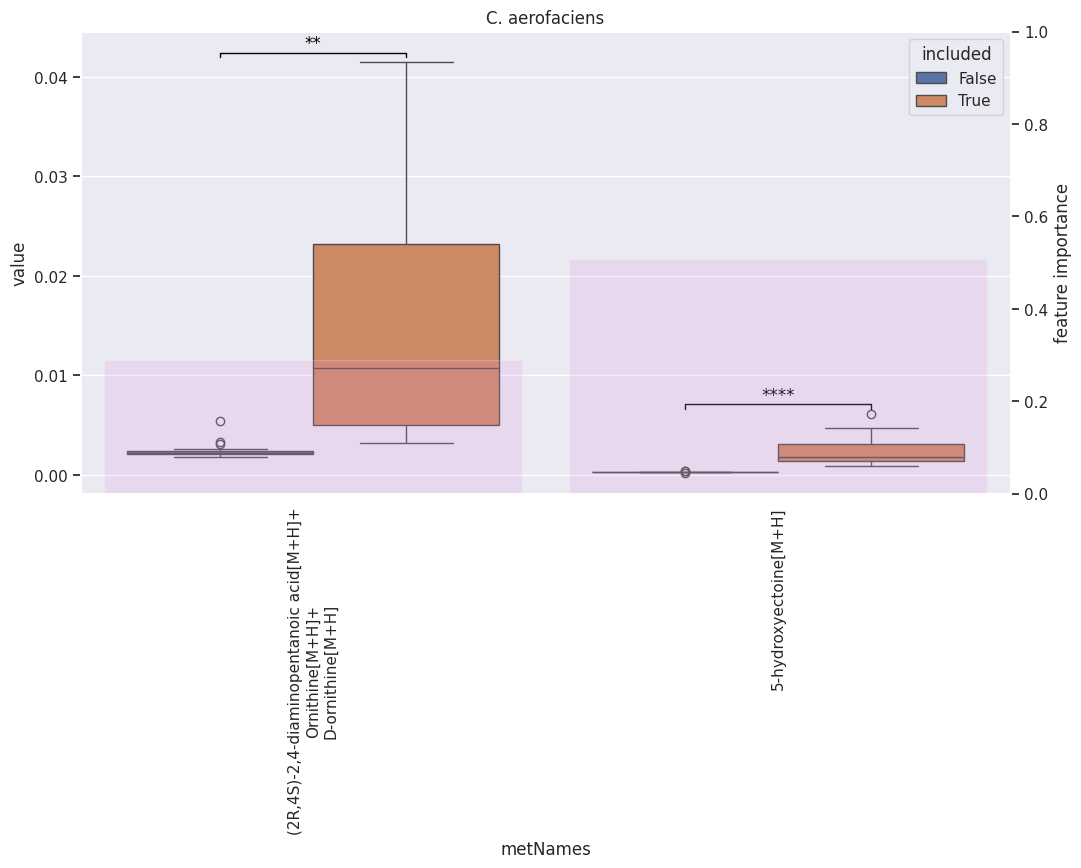

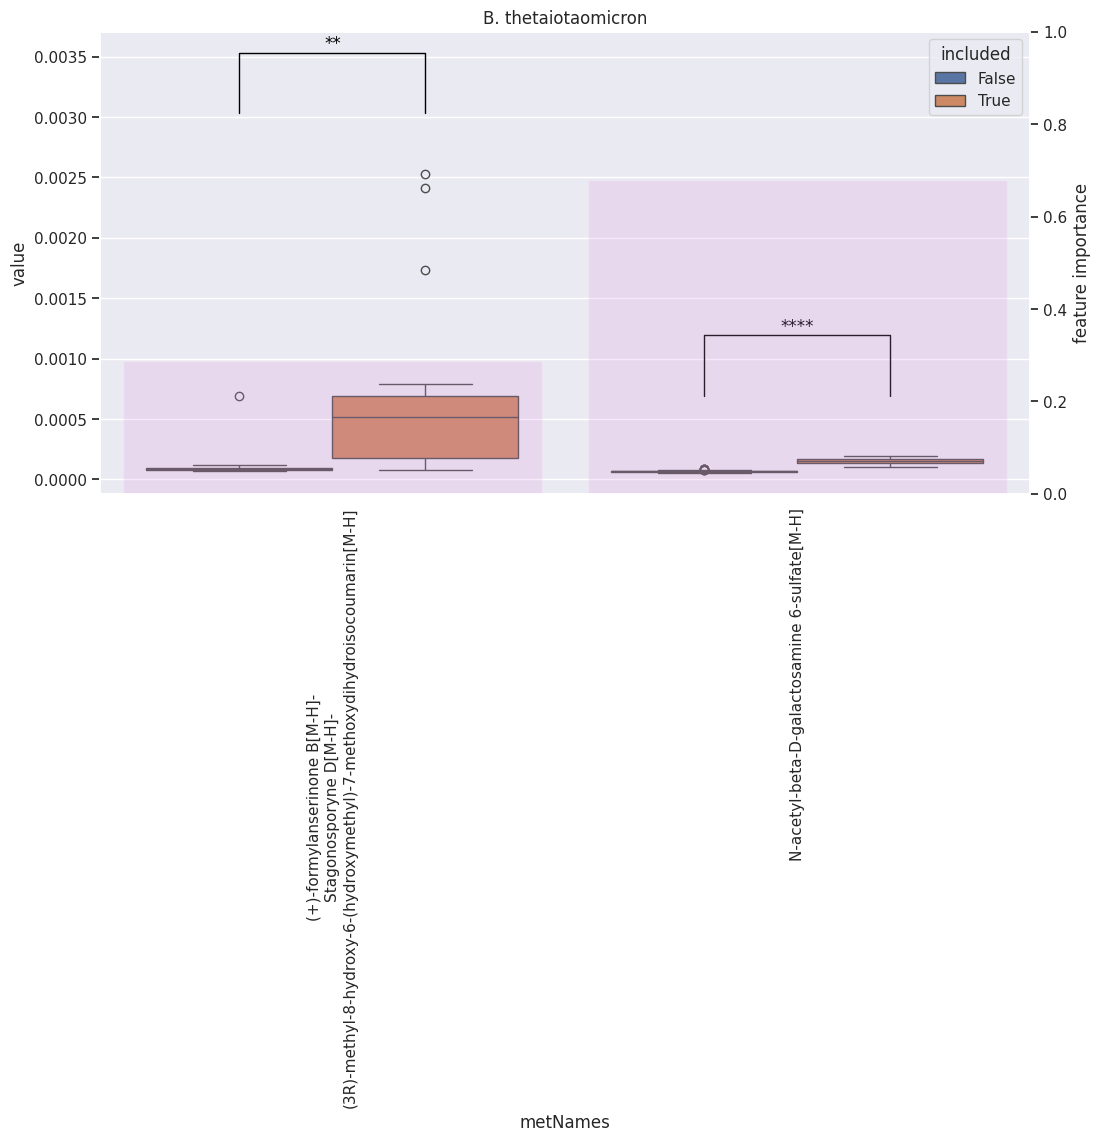

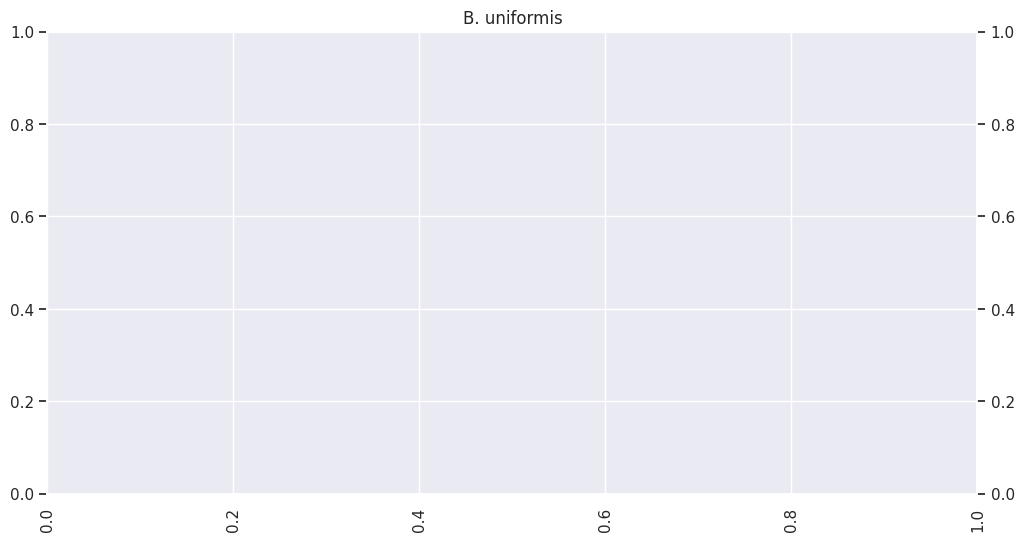

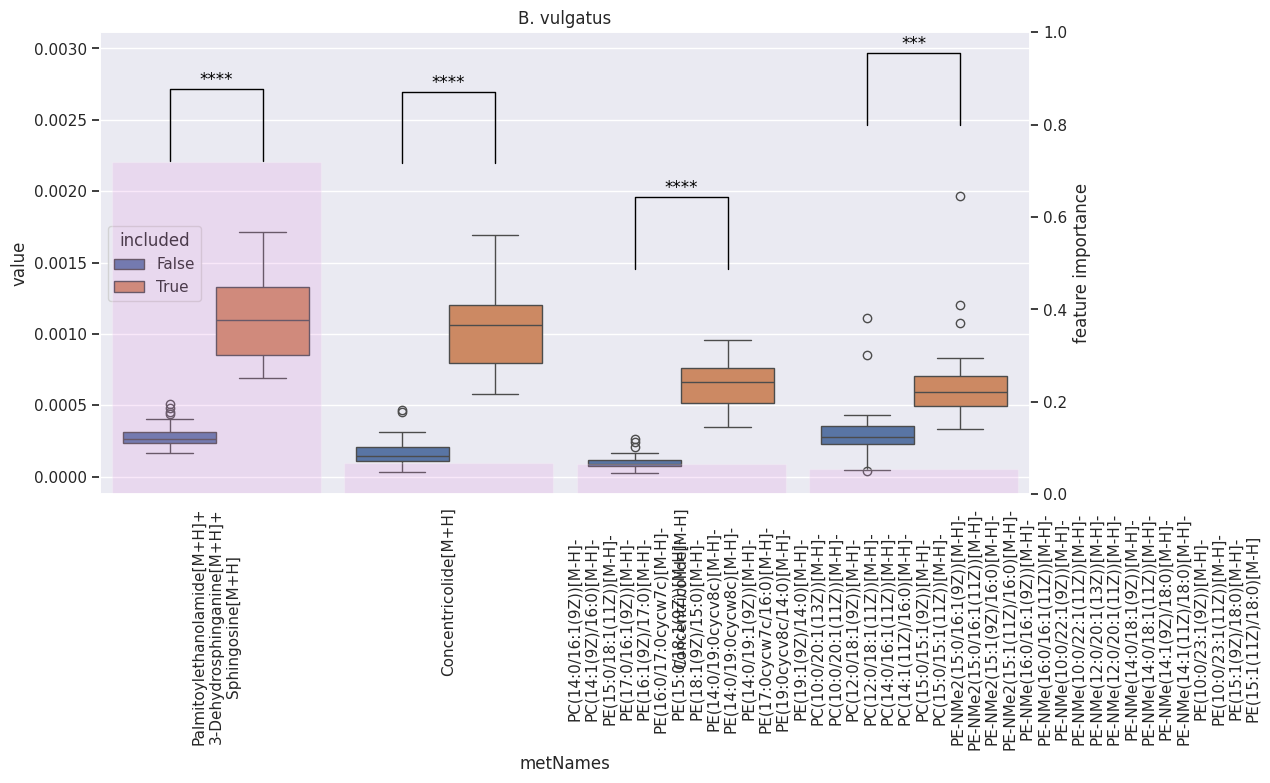

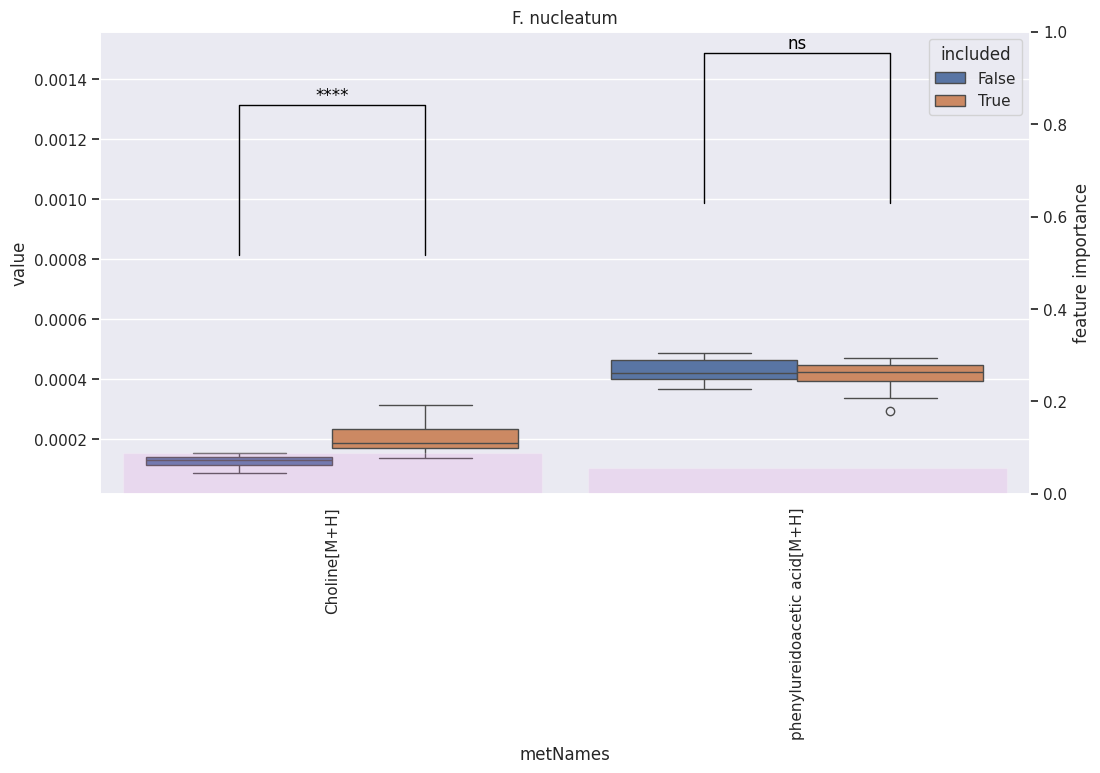

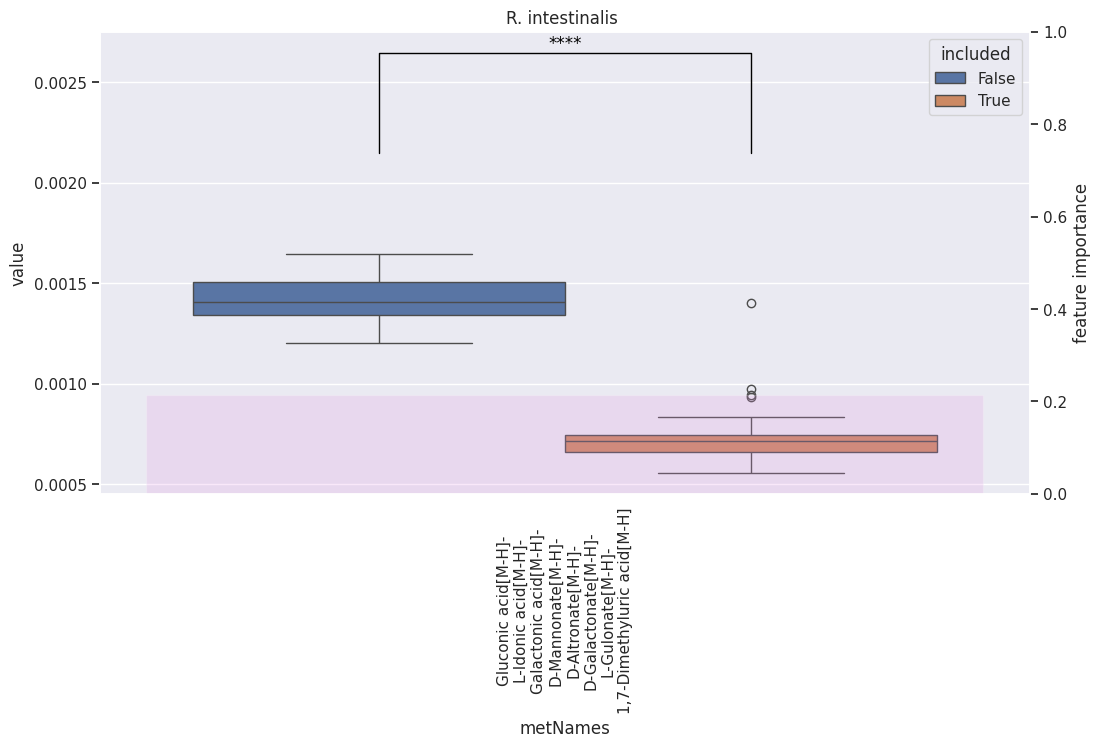

In [21]:
plots = importance_significance_plot_batch(test_stats, importances_df, includes)